<a href="https://colab.research.google.com/github/vitalns/dim_reduction/blob/main/dim_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-success">
<font size="5" color="blue">Методы уменьшение размерности данных </font>
<font size="7">✂️</font>
</div>
<p><b><i>Описание:</i></b>
На примере датасета "penguins" рассмотрены с визуализацией линейные и нелинейные методы уменьшения размерности данных:

- метод главных компонент (PCA - Principal component analysis);
- t-SNE (t-distributed Stochastic Neighbor Embedding);
- UMAP (Uniform Manifold Approximation and Projection).

Статьи по теме:
1. https://habr.com/ru/articles/751050/ - обзор линейных и нелинейных методов
2. https://habr.com/ru/companies/otus/articles/757030/ - хорошо описана математика метода PCA и t-SNE;

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [90]:
pip install umap-learn # UMAP иногда напрямую не импортируется

In [91]:
import umap

In [65]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# *Анализ данных*

In [66]:
# Загрузим датасет

penguins = sns.load_dataset("penguins")
penguins.dropna(inplace=True)
penguins.reset_index(drop=True, inplace=True)
penguins.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female


In [67]:
# Разделим числовые и категориальные данные
penguins_data = penguins.select_dtypes(np.number)
penguins_info = penguins.select_dtypes(exclude='float')

# Масштабируем данные
data_scaled = StandardScaler().fit_transform(penguins_data)

In [68]:
# Создадим таблицу со средними значениями.

species = penguins.species.unique()

try:
  averages = [penguins[penguins['species']==i].mean().to_list() for i in species] # Раньше так работало
except:
  # mean применяем толко к слобцам с числовыми данными
  averages = [penguins[penguins['species']==i][penguins.select_dtypes(np.number).columns].mean().to_list() for i in species]

avg_data = pd.DataFrame(averages, columns=penguins.select_dtypes(np.number).columns)
avg_data['species'] = species
avg_data

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,species
0,38.823973,18.347260,190.102740,3706.164384,Adelie
1,48.833824,18.420588,195.823529,3733.088235,Chinstrap
2,47.568067,14.996639,217.235294,5092.436975,Gentoo


In [69]:
# Добавим средние значения к общей таблице.

avg = avg_data.copy(deep=True)
avg.species = 'mean' # Добавляем заглушку для hue в pairgrid.
data_all = pd.concat([penguins, avg], ignore_index=True)
data_all.tail()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
331,Gentoo,Biscoe,45.200000,14.800000,212.000000,5200.000000,Female
332,Gentoo,Biscoe,49.900000,16.100000,213.000000,5400.000000,Male
333,mean,NaN,38.823973,18.347260,190.102740,3706.164384,NaN
334,mean,NaN,48.833824,18.420588,195.823529,3733.088235,NaN
335,mean,NaN,47.568067,14.996639,217.235294,5092.436975,NaN


## Парная диаграмма

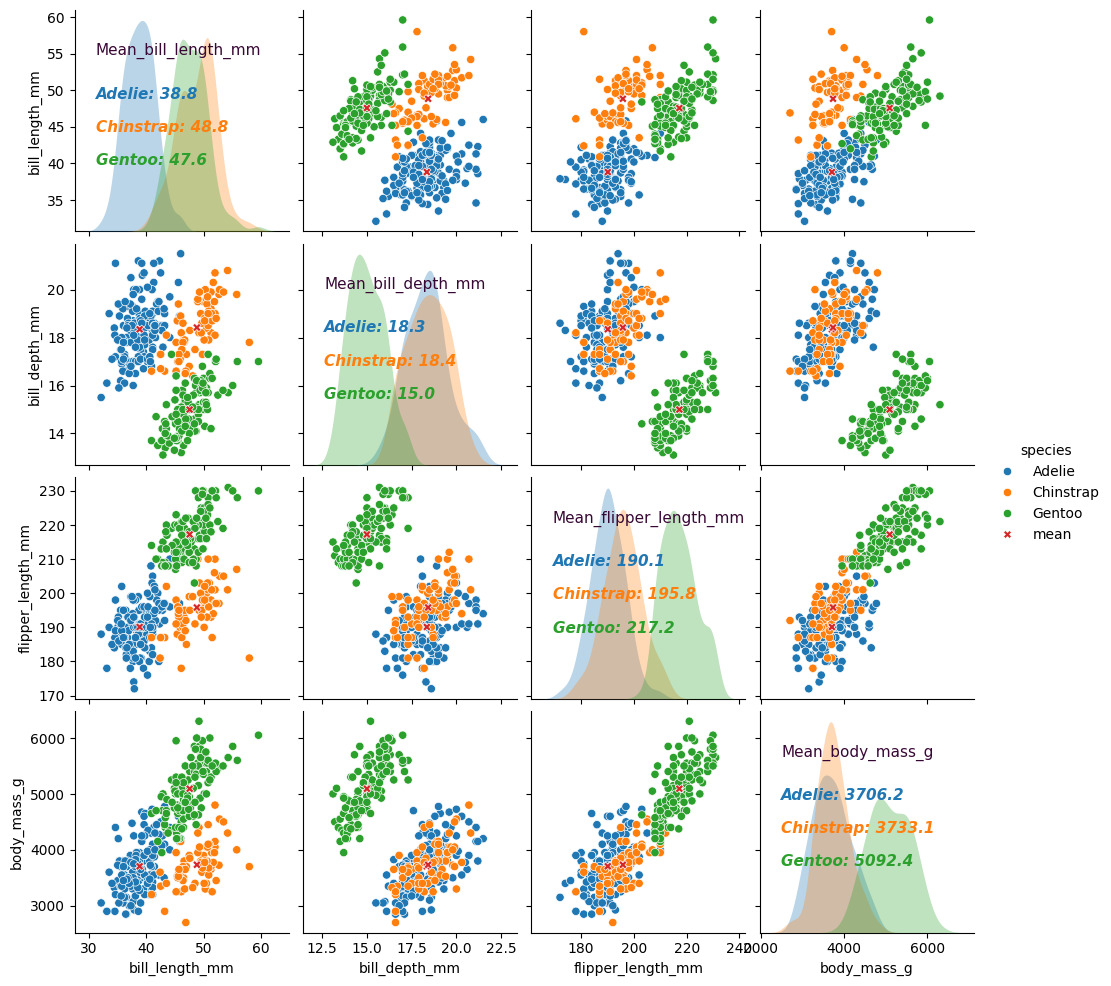

In [70]:
# Построим парную диаграмму с помощью pairplot и добавим средние значения на график.

g = sns.pairplot(data=data_all,
                 hue='species',
                 diag_kind='None', # На диагональ добавим графики отдельно без средних значений
                 markers=['o', 'o', 'o', 'X'],
                 #palette='tab10',  # по умолчанию
                 )

# Создадим словарь, устанавливающий соответствие между species и цветом.
cmap_hue = dict(zip(g._hue_order[:3], sns.color_palette('tab10')[:3]))

def annotate_func(*args, **kwargs):
  data = args[0]
  mean = data.mean()
  ax = plt.gca()
  # Каждое значения species из списка hue нужно записать с новой строки,
  # поэтому будем считать сколько экземпляров дочернего класса matplotlib.text.Annotation уже есть.
  # Можно считать экземпляры matplotlib.text.Text, но так как на графике уже есть подписи, то начальное значение не нулевое.
  n = len([c for c in ax.get_children() if isinstance(c, matplotlib.text.Annotation)])
  pos = (.1, .6 - .15*n)
  if n == 0:  # Добавим заглавие фичи для которой вычесляем среднее
    ax.text(.1,.85,
            f"Mean_{args[0].name}",
            size=11, weight='roman', stretch='condensed', color='xkcd:eggplant',
            va='top',  # По умолчанию ha='left' и va='bottom'
            transform=ax.transAxes
            )
  if kwargs['label'] in g._hue_order[:3]:  # Добавим среднее для всех species из фрейма, кроме mean.
    sns.kdeplot(data, fill=True, linewidth=0, alpha=0.3)  # Добавить график без заливки в качестве фона.
    ax.annotate(f"{kwargs['label']}: {mean:.1f}",
                size=11, style='oblique', weight='semibold',
                c=cmap_hue[kwargs['label']],
                xy=pos, xycoords=ax.transAxes
                )
g.map_diag(annotate_func)

___

# *Уменьшение размерности данных*

## Метод главных компонент (Principal component analysis)

*Заметки:*
- Полезен для визуализации глобальных паттернов в данных (позволяет сохранить глобальные структуры данных и обнаруживать линейные зависимости);
- PCA является методом линейного снижения размерности, поэтому хорошо работает, когда **между признаками линейные связи**;
- Важным шагом является **центррование данных**;
- Чувствителен к выбросам в данных, это можно учесть путём **стандартизации данных** (выбросы значительно влияют на определение главных компонент).

In [71]:
%%time

# Собирём пайплайн для масштабирования и преобразования PCA
reducer_pca = make_pipeline(StandardScaler(),  # Масштабирование данных очень важно для PCA! (центровка и стандартизация (нулевое среднее и единичная дисперсия))
                            PCA(n_components=4, random_state=12345))
dimension_pca = reducer_pca.fit_transform(penguins_data)  # Применяем PCA к числовых данных

CPU times: user 7.11 ms, sys: 0 ns, total: 7.11 ms
Wall time: 22.7 ms


In [72]:
# Можно посмотреть результат масштабирования
reducer_pca.named_steps['standardscaler'].fit_transform(penguins_data)[:3]

array([[-0.89604189,  0.7807321 , -1.42675157, -0.56847478],
       [-0.82278787,  0.11958397, -1.06947358, -0.50628618],
       [-0.67627982,  0.42472926, -0.42637319, -1.1903608 ]])

In [73]:
# Можно посмотреть на установки PCA
reducer_pca.named_steps['pca']

PCA(n_components=4, random_state=12345)

In [74]:
# Посмотрим значимость полученных компонент в процентах ("доля объясненной дисперсии").
var_explained = reducer_pca.named_steps['pca'].explained_variance_ratio_*100
var_explained

array([68.63389314, 19.45292928,  9.21606299,  2.69711459])

*Примечание:*

Первая компонента "объясняет" 68.6% вариации данных, вторая - 19.4%, третья - 9.2%, четвертая - 2.7%.

*Вывод:*

При необходимости четвертую компоненту можно отбросить.

In [75]:
# Собирем таблицу с преобразованными данными

data_pca = pd.DataFrame(data=dimension_pca,
                        columns=['PC1', 'PC2','PC3', 'PC4'])
data_pca['Species'] = penguins.species
data_pca['Sex'] = penguins.sex
data_pca.head(3)

,PC1,PC2,PC3,PC4,Species,Sex
0,-1.853593,0.032069,-0.234902,0.528397,Adelie,Male
1,-1.316254,-0.443527,-0.027470,0.401727,Adelie,Female
2,-1.376605,-0.161230,0.189689,-0.528662,Adelie,Female


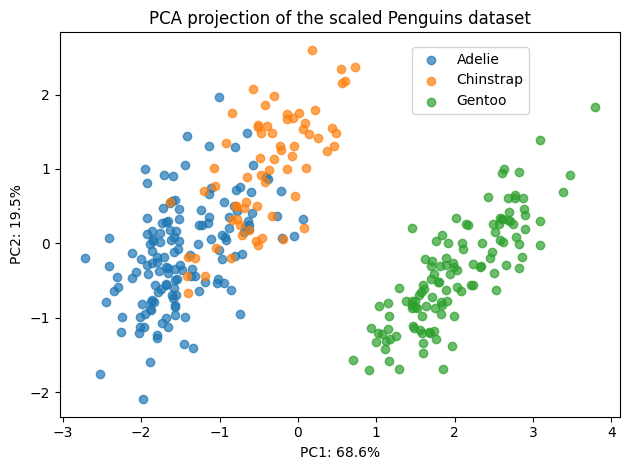

In [76]:
# Постороим диаграмму рассеяния для пары весомых признаков PC1 и PC2, используя matplotlib.

fig, ax = plt.subplots()
for species in ["Adelie", "Chinstrap", "Gentoo"]:
  plt.scatter(data_pca[data_pca.Species == species]['PC1'],
            data_pca[data_pca.Species == species]['PC2'],
            marker='o', alpha=.7,
            label=species)



plt.title("PCA projection of the scaled Penguins dataset")
plt.xlabel("PC1: "+f'{var_explained[0]:.1f}'+"%")
plt.ylabel("PC2: "+f'{var_explained[1]:.1f}'+"%")
plt.legend(bbox_to_anchor=(.85, .98))
fig.tight_layout()  # plt.tight_layout()
plt.show()

# Сделаем квадратный график.
# ax.set_aspect(.75, 'box')  # Не получилось настроить соотношение осей???
# # plt.gca().set_aspect('equal', 'datalim')

# # Сохраним данные легенды, пригодяться ниже.
# # ax = plt.gca()
# h, l = ax.get_legend_handles_labels()

# # Можно построить без цикла и создать список цветов для маркеров, но легенду автоматически не добавить.
# plt.scatter(data_pca.PC1, data_pca.PC2,
#             c=[sns.color_palette()[x] for x in penguins.species.map({
#             "Adelie":1, "Chinstrap":0, "Gentoo":2})],
#             marker='o', alpha=.7)

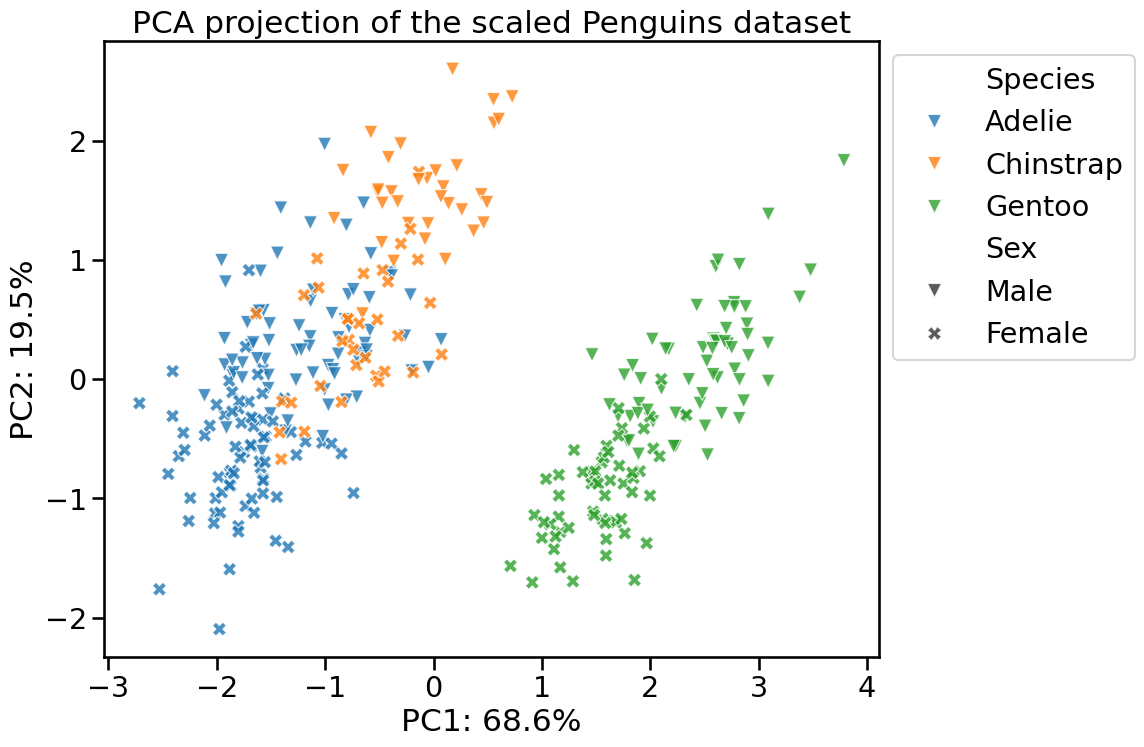

In [77]:
# Постороим диаграмму рассеяния для пары весомых признаков PC1 и PC2, используя seaborn.

plt.figure(figsize=(10,8))
with sns.plotting_context("talk",font_scale=1.25):
    sns.scatterplot(x="PC1", y="PC2",
                    data=data_pca,
                    hue="Species",
                    style="Sex",
                    markers={'Female':'X', 'Male':'v'},
                    s=100, alpha=0.8
                    )
    plt.xlabel("PC1: "+f'{var_explained[0]:.1f}'+"%")
    plt.ylabel("PC2: "+f'{var_explained[1]:.1f}'+"%")
    plt.title("PCA projection of the scaled Penguins dataset")
    plt.legend(bbox_to_anchor=(1, 1))
plt.savefig("PCA_plot_PC1_vs_PC2_Penguins_scaled_data.png",
                                              format='png',dpi=150)

*Заметки:*
- С помощью PCA удалось выделить представителей Gentoo в отдельную группу, но к ним подмешены несколько самок и самцов Chinstrap;
- Виды Adelie и Chinstrap по-прежнему сильно перемешаны.

___

## t-SNE (t-distributed Stochastic Neighbor Embedding)

*Заметки:*
- Полезен для визуализации скрытых паттернов в данных (позволяет сохранить локальные структуры данных и обнаруживать нелинейные зависимости);
-

In [78]:
%%time

# Применим t-SNE к масштабированным данным и уменьшаем размерность до 2 признаков (n_components=2)

reducer_tsne = TSNE(n_components=2, # по умолчанию
                    perplexity=30,  # по умолчанию
                    early_exaggeration=12,  # по умолчанию
                    random_state=12345
                    )
dimension_tsne = reducer_tsne.fit_transform(data_scaled)

CPU times: user 4 s, sys: 13.8 ms, total: 4.01 s
Wall time: 2.47 s


In [79]:
# Собирем таблицу с преобразованными данными
data_tsne = pd.DataFrame(data = dimension_tsne,
        columns = ['F1', 'F2'])
data_tsne['Species'] = penguins.species
data_tsne['Sex'] = penguins.sex
data_tsne.head(3)

,F1,F2,Species,Sex
0,-11.964678,-5.030074,Adelie,Male
1,-15.165598,-7.658165,Adelie,Female
2,-16.854551,-6.065064,Adelie,Female


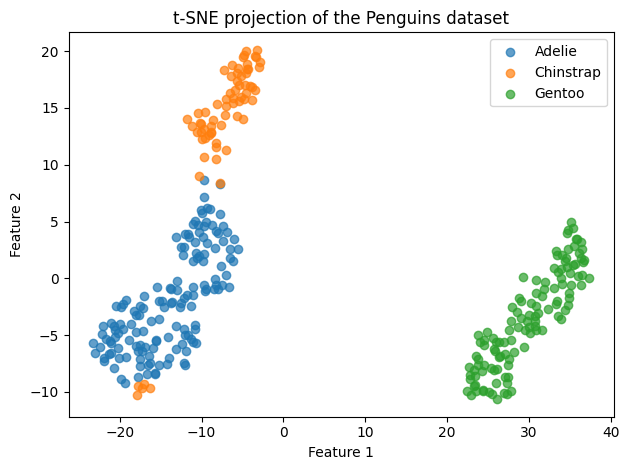

In [80]:
# Постороим диаграмму рассеяния для пары признаков F1 и F2, используя matplotlib.

fig, ax = plt.subplots()
for species in ["Adelie", "Chinstrap", "Gentoo"]:
  plt.scatter(data_tsne[data_tsne.Species == species]['F1'],
              data_tsne[data_tsne.Species == species]['F2'],
              marker='o', alpha=.7,
              label=species)

# plt.scatter(dimension_tsne[:, 0],
#             dimension_tsne[:, 1],
#             c=[sns.color_palette()[x] for x in penguins.species.map({
#                 "Adelie":1, "Chinstrap":0, "Gentoo":2})],
#             marker='o', alpha=.7
#             )

plt.title("t-SNE projection of the Penguins dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.tight_layout()
plt.show()

['species', 'Adelie', 'Chinstrap', 'Gentoo', 'sex', 'Male', 'Female']

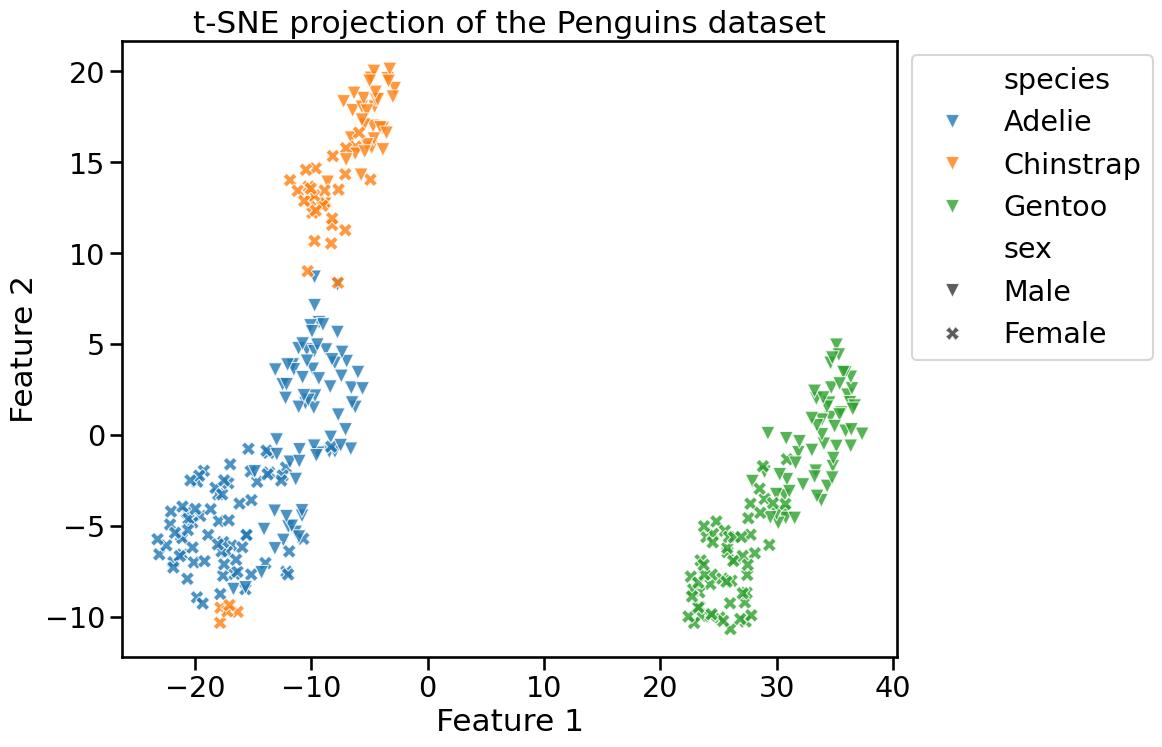

In [99]:
# Построим диаграмму рассеяния пары признаков F1 и F2, используя seaborn.
# У sns.scatterplot больше возможностей, чем у plt.scatter.

plt.figure(figsize=(10,8))  # fig, ax = plt.subplots(figsize=(10,8))
with sns.plotting_context("talk",font_scale=1.25):
  p = sns.scatterplot(x=dimension_tsne[:, 0], y=dimension_tsne[:, 1],
                  data=penguins_info,
                  hue='species',
                  style='sex',
                  markers={'Female':'X', 'Male':'v'},
                  s=100, alpha=.8
                  )
  plt.title("t-SNE projection of the Penguins dataset")
  plt.legend(bbox_to_anchor=(1, 1))
  plt.xlabel("Feature 1")
  plt.ylabel("Feature 2")

# Сохраним данные легенды, пригодяться ниже.
ax = plt.gca()
h, l = ax.get_legend_handles_labels()

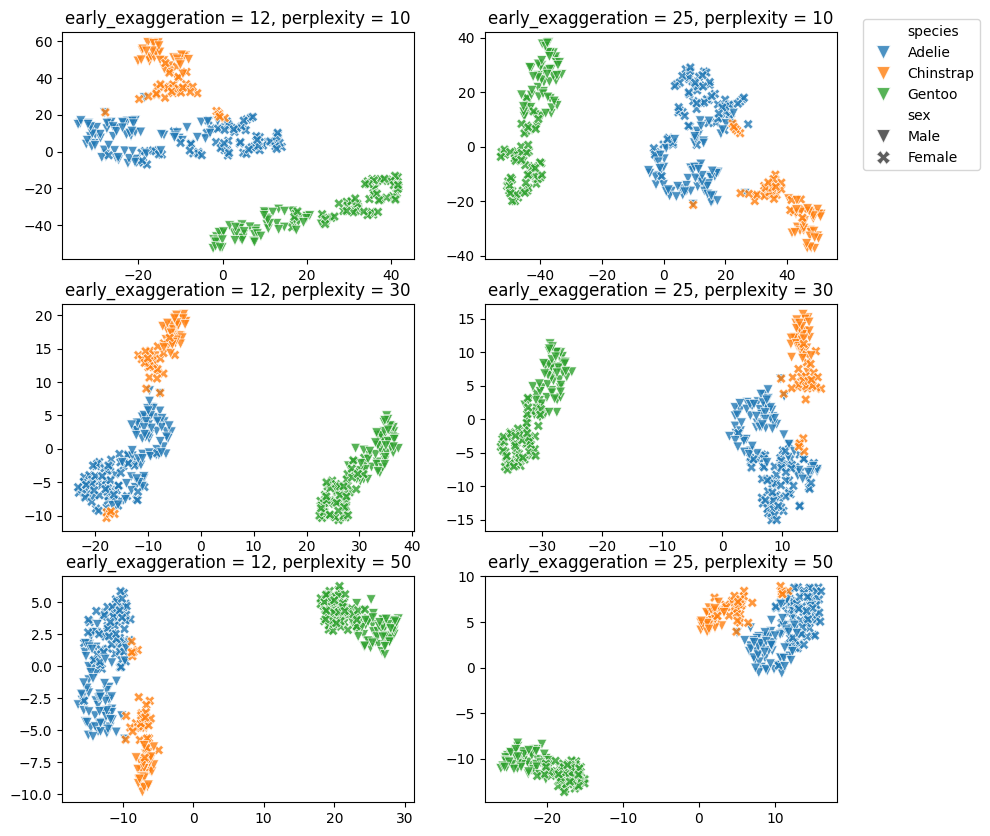

In [100]:
# Перебор параметров алгоритма t-SNE

fig, axes = plt.subplots(3, 2, figsize=(10, 10))
data_tsne = penguins_info.copy(deep=True)
for i, perplexity in enumerate([10, 30, 50]):  # Этот гиперпараметр учитывает число соседей (высокое значение подчеркивает глобальную структуру, низкое - локальную).
  for j, early_exaggeration in enumerate([12, 25]):
    reducer = TSNE(perplexity=perplexity,
                   early_exaggeration=early_exaggeration,
                   random_state=12345).\
                   fit_transform(data_scaled)
    data_tsne['x'] = reducer[:, 0]
    data_tsne['y'] = reducer[:, 1]
    sns.scatterplot(ax=axes[i, j],
                    x="x", y="y",
                    data=data_tsne,
                    hue='species',
                    style='sex',
                    markers={'Female':'X', 'Male':'v'},
                    s=50, alpha=0.8,
                    legend=None
                    )
    axes[i, j].set_title(f'early_exaggeration = {early_exaggeration}, perplexity = {perplexity}',
                         fontdict={'fontsize':12})
    axes[i, j].set(xlabel=None, ylabel=None)

fig.legend(h, l, bbox_to_anchor=(1.05, 0.9))  # Параметры (h, l) для легенды определены на диаграмме выше.

*Заметки:*
- t_SNE хорошо справляется с разделением пингвинов на виды, несколько девчонок Chistrap примкнули к девчонкам Adelie;
- При вариации гиперпараметров perplexity и early_exaggeration общая картина сохраняется, число ошибочных присвоений к другому виду не меняется;
- С ростом perplexity группы становяться более локализованные и граница между мальчишками и девчонками становится менее чёткая.

___

## UMAP (Uniform Manifold Approximation and Projection)

In [84]:
%%time

# Применим umap к масштабированным данным и уменьшаем размерность до 2 признаков (n_components=2)

umap = umap.UMAP(# n_components=2, # значение по умолчанию 2
                    # n_neighbors=15, # значение по умолчанию 15
                    # min_dist=0.1, # значение по умолчанию 0.1
                    # metric='euclidean' # значение по умолчанию euclidean
                    )
reducer_umap = umap.fit_transform(data_scaled)
reducer_umap.shape

CPU times: user 3.1 s, sys: 30.9 ms, total: 3.13 s
Wall time: 2.82 s


(333, 2)

In [85]:
# Собирем таблицу с преобразованными данными

data_umap = pd.DataFrame(data = reducer_umap,
                         columns = ['F1', 'F2'])
data_umap['Species'] = penguins.species
data_umap['Sex'] = penguins.sex
data_umap.head(3)

,F1,F2,Species,Sex
0,9.516634,3.821936,Adelie,Male
1,9.389395,4.767228,Adelie,Female
2,8.630348,4.733821,Adelie,Female


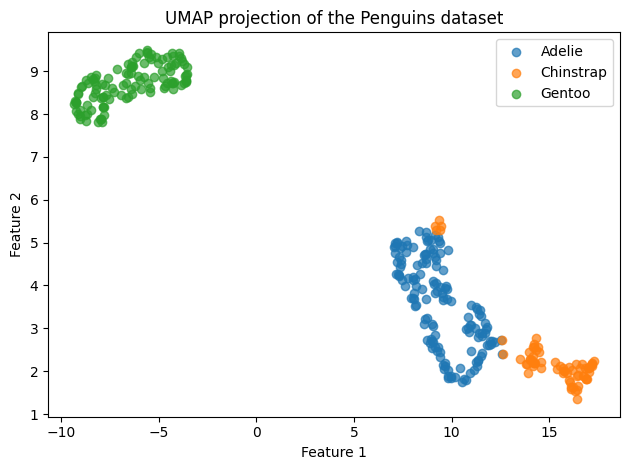

In [86]:
# Построим диаграмму рассеяния пары признаков F1 и F2, полученных с UMAP, используя matplotlib.

fig, ax = plt.subplots()
for species in ["Adelie", "Chinstrap", "Gentoo"]:
  plt.scatter(data_umap[data_umap.Species == species]['F1'],
              data_umap[data_umap.Species == species]['F2'],
              marker='o', alpha=.7,
              label=species)

# plt.scatter(reducer_umap[:, 0],
#             reducer_umap[:, 1],
#             c=[sns.color_palette()[x] for x in penguins.species.map({
#                 "Adelie":1, "Chinstrap":0, "Gentoo":2})],
#             marker='o', alpha=.7
#             )

plt.title("UMAP projection of the Penguins dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

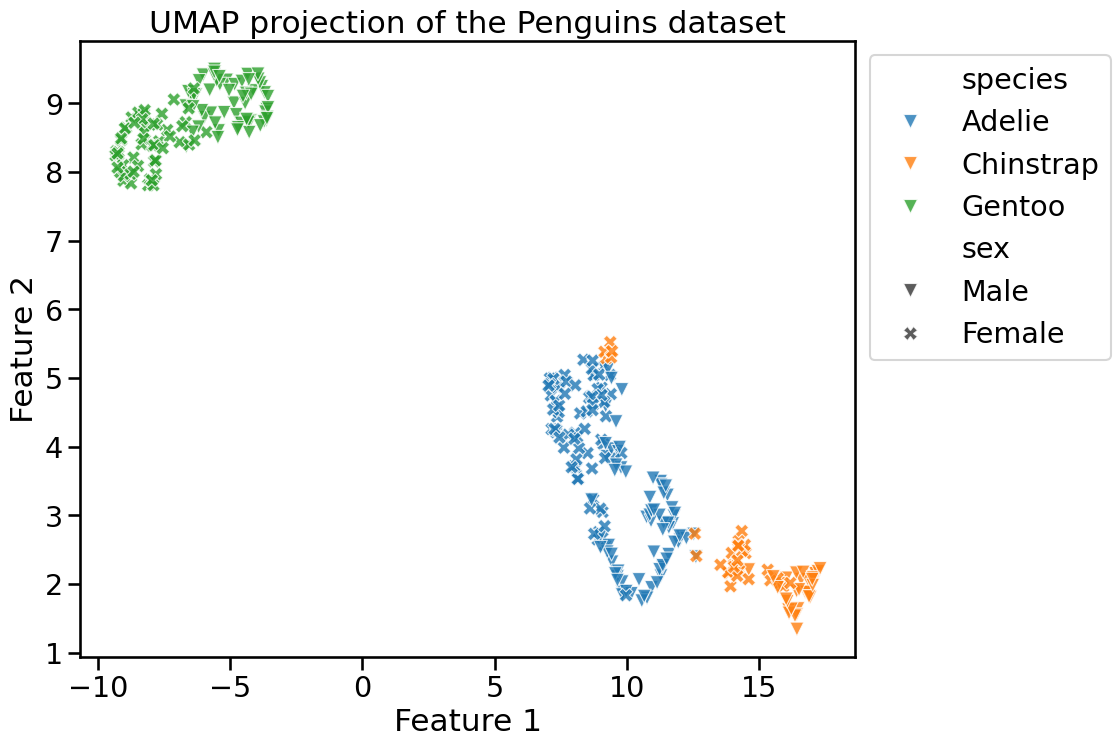

In [87]:
# Построим диаграмму рассеяния пары признаков, полученных с UMAP, используя seaborn.
# У sns.scatterplot больше возможностей, чем у plt.scatter.

# fig, ax = plt.subplots(figsize=(10,8))
plt.figure(figsize=(10,8))
with sns.plotting_context("talk",font_scale=1.25):
  sns.scatterplot(x=reducer_umap[:, 0], y=reducer_umap[:, 1],
                  data=penguins_info,
                  hue='species',
                  style='sex',
                  markers={'Female':'X', 'Male':'v'},
                  s=100, alpha=.8
                  )
  plt.title("UMAP projection of the Penguins dataset")
  plt.legend(bbox_to_anchor=(1, 1))
  plt.xlabel("Feature 1")
  plt.ylabel("Feature 2")

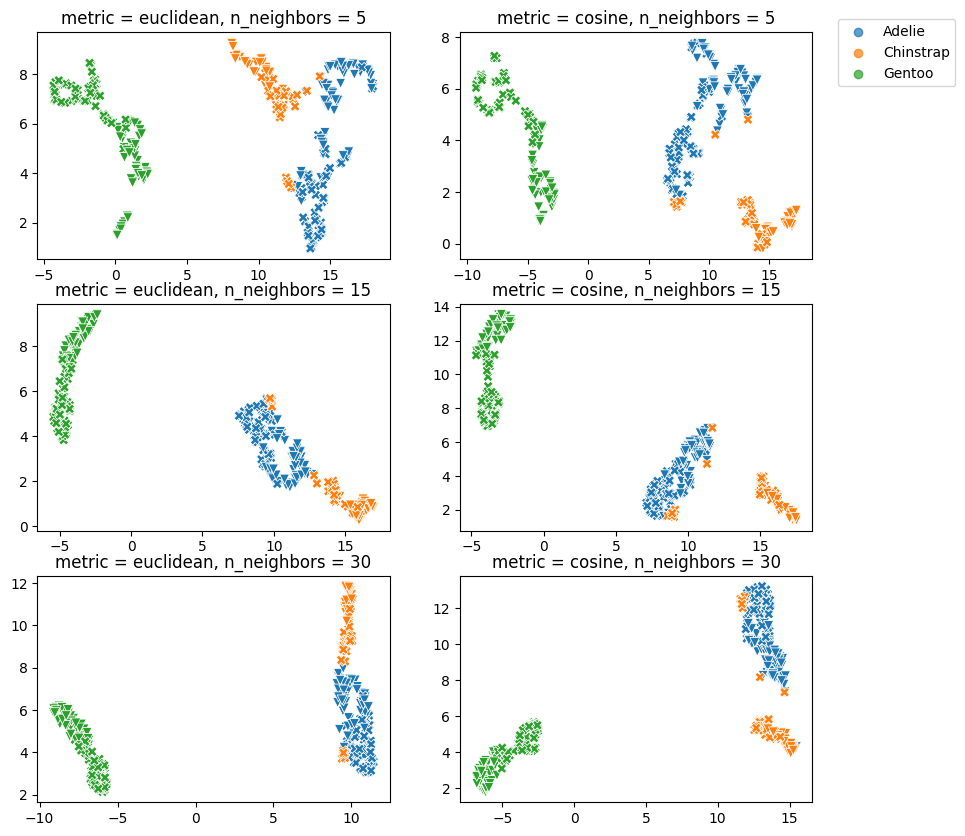

In [92]:
# Перебор параметров алгоритма UMAP

fig, axes = plt.subplots(3, 2, figsize=(10, 10))
data_umap = penguins_info.copy(deep=True)
for i, n_neighbors in enumerate([5, 15, 30]):
  for j, metric in enumerate(['euclidean', 'cosine']):
    reducer = umap.UMAP(n_neighbors=n_neighbors,
                        # min_dist=min_dist,
                        metric=metric).\
                        fit_transform(data_scaled)
    data_umap['x'] = reducer[:, 0]
    data_umap['y'] = reducer[:, 1]
    sns.scatterplot(ax=axes[i, j],
                    x="x", y="y",
                    data=data_umap,
                    hue='species',
                    style='sex',
                    markers={'Female':'X', 'Male':'v'},
                    s=50, alpha=.8,
                    legend=None
                    )
    axes[i, j].set_title(f'metric = {metric}, n_neighbors = {n_neighbors}')
    axes[i, j].set(xlabel=None, ylabel=None,
                  # xlim=(-15,20), ylim=(-5,15)
                  )
fig.legend(h, l, bbox_to_anchor=(1.05, 0.9))  # Параметры (h, l) для легенды определены на диаграмме выше.

*Заметки:*
- UMAP хорошо справляется с разделением пингвинов на виды, несколько девчонок Chistrap примкнули к девчонкам Adelie и один парень Adelie примкнули к парням Chistrap;
- С ростом числа соседей общая картина не сильно меняется;
- С параметром metric='cosine' виды более локализованны в группы, но ещё больше девчонок Chistrap примыкает к Adelie;


___